In [13]:
import numpy as np
import torch
from graph_traffic.train_gnn import test_model, predict
import matplotlib.pyplot as plt
import pandas as pd
from graph_traffic.config import training_path
from graph_traffic.model_selection import get_node_ids
from graph_traffic.get_data import ubs_index
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib.ticker import MaxNLocator

months = ["Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
ids_list = get_node_ids()
_, ubs_dict = ubs_index(ids_list)

df = pd.read_csv(f"{training_path}/gnn-results.csv", sep=";", usecols=["nombre", "evaluate_in", "seq_len", "epoch_selected", "config"])

In [15]:
maes = dict()
mses = dict()
for config in range(1, 6):
    print("config", config)
    maes[config] = dict()
    mses[config] = dict()
    for seq_len in [2, 4, 8, 16]:
        print("seq len", seq_len)
        maes[config][seq_len] = dict()
        mses[config][seq_len] = dict()
        for evaluate_in in months:
            print("evaluate month", evaluate_in, end="\r")
            maes[config][seq_len][evaluate_in] = dict()
            mses[config][seq_len][evaluate_in] = dict()
            for i in ids_list:
                maes[config][seq_len][evaluate_in][i] = []
                mses[config][seq_len][evaluate_in][i] = []
            row = df.loc[(df.evaluate_in==evaluate_in) & (df.seq_len==seq_len) & (df.config==config)].iloc[0]
            if np.isnan(row["epoch_selected"]):
                continue
            model_name = row["nombre"]
            epoch = int(row["epoch_selected"])
            model, test_loader, norm_layer, batch_size, graph = test_model(model_name, epoch=epoch)
            for x, y in test_loader:
                all = np.concatenate([x, y], axis=1)[..., 0]
                _, pred = predict(x, y, batch_size, graph, model, torch.device('cpu'), norm_layer)
                y = y[..., 0].detach().numpy()
                #y_modif = y_modif[:, :y.shape[0]*37, 0]
                pred = pred.detach().numpy()[:, :y.shape[0]*37, 0]
                pred = pred.reshape(-1, pred.shape[0], 37)
                for i in ids_list:
                    graph_id = ubs_dict[i]
                    pred_i = pred[:, :, graph_id]
                    y_i = y[:, :, graph_id]
                    maes[config][seq_len][evaluate_in][i].append(mean_absolute_error(pred_i, y_i))
                    mses[config][seq_len][evaluate_in][i].append(mean_squared_error(pred_i, y_i))

config 1
seq len 2


KeyboardInterrupt: 

In [19]:
def get_mean(l):
    if len(l) == 0:
        return np.nan
    else:
        return np.nanmean(l)

In [20]:
for config in range(1, 6):
    for seq_len in [2, 4, 8, 16]:
        maes_df = pd.DataFrame(maes[config][seq_len]).applymap(get_mean).sort_index()
        maes_df["avg"] = maes_df.loc[:, :"Dec"].mean(axis=1)
        maes_df["std"] = maes_df.loc[:, :"Dec"].std(axis=1)
        maes_df.round(4).to_csv(f"{training_path}/gnn/config{config}/maes_{seq_len}.csv")

In [21]:
for config in range(1, 6):
    for seq_len in [2, 4, 8, 16]:
        mses_df = pd.DataFrame(mses[config][seq_len]).applymap(get_mean).sort_index()
        mses_df["avg"] = mses_df.loc[:, :"Dec"].mean(axis=1)
        mses_df["std"] = mses_df.loc[:, :"Dec"].std(axis=1)
        mses_df.round(4).to_csv(f"{training_path}/gnn/config{config}/mses_{seq_len}.csv")

# Cualitativo

In [25]:
def get_plot(evaluate_in, seq_len, node_id):
    graph_id = ubs_dict[node_id]
    fig, axs = plt.subplots(3, 2, figsize=(20, 8))
    for config in [1, 2, 3, 4, 5]:
        row = df.loc[(df.evaluate_in==evaluate_in) & (df.seq_len==seq_len) & (df.config==config)].iloc[0]
        model_name = row["nombre"]
        epoch = int(row["epoch_selected"])
        model, test_loader, norm_layer, batch_size, graph = test_model(model_name, epoch=epoch)
        for x, y in test_loader:
            all = np.concatenate([x, y], axis=1)[..., 0]
            _, pred = predict(x, y, batch_size, graph, model, torch.device('cpu'), norm_layer)
            y = y[..., 0].detach().numpy()
            #y_modif = y_modif[:, :y.shape[0]*37, 0]
            pred = pred.detach().numpy()[:, :y.shape[0]*37, 0]
            pred = pred.reshape(-1, pred.shape[0], 37)
            break

        pred_i = pred[:, :, graph_id]
        pred_rep = [all[0, seq_len, graph_id]] * seq_len
        pred_rep_all = all[0, :seq_len, graph_id]
        drift_per_period = (all[0, seq_len, graph_id] - all[0, 0, graph_id]) / seq_len
        drift_pred = [all[0, seq_len, graph_id] + i*drift_per_period for i in range(1, seq_len+1)]
        all_i = all[:, :, graph_id]
        n_row = (config-1) // 2
        n_column = (config-1) % 2
        ax = axs[n_row, n_column]
        ax.plot(range(2*seq_len), all_i[0], "x-", alpha=0.2, color="black", label="Tráfico real")
        ax.plot(range(seq_len, 2*seq_len), pred_i[0], "x-", label=f"gnn_config{config}")
        ax.plot(range(seq_len, 2*seq_len), pred_rep_all, "x-", label="repeat")
        ax.plot(range(seq_len, 2*seq_len), pred_rep, "x-", label="repeat_last")
        ax.plot(range(seq_len, 2*seq_len), drift_pred, "x-", label="drift")
        ax.set_title(f"Config. {config}")
        ax.set_xlabel("Períodos de 15 minutos")
        #ax.set_xticks(range(2*seq_len))
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.set_ylabel("Ocupación [%]")
        ax.legend()
    fig.tight_layout()
    axs[2, 1].axis("off")

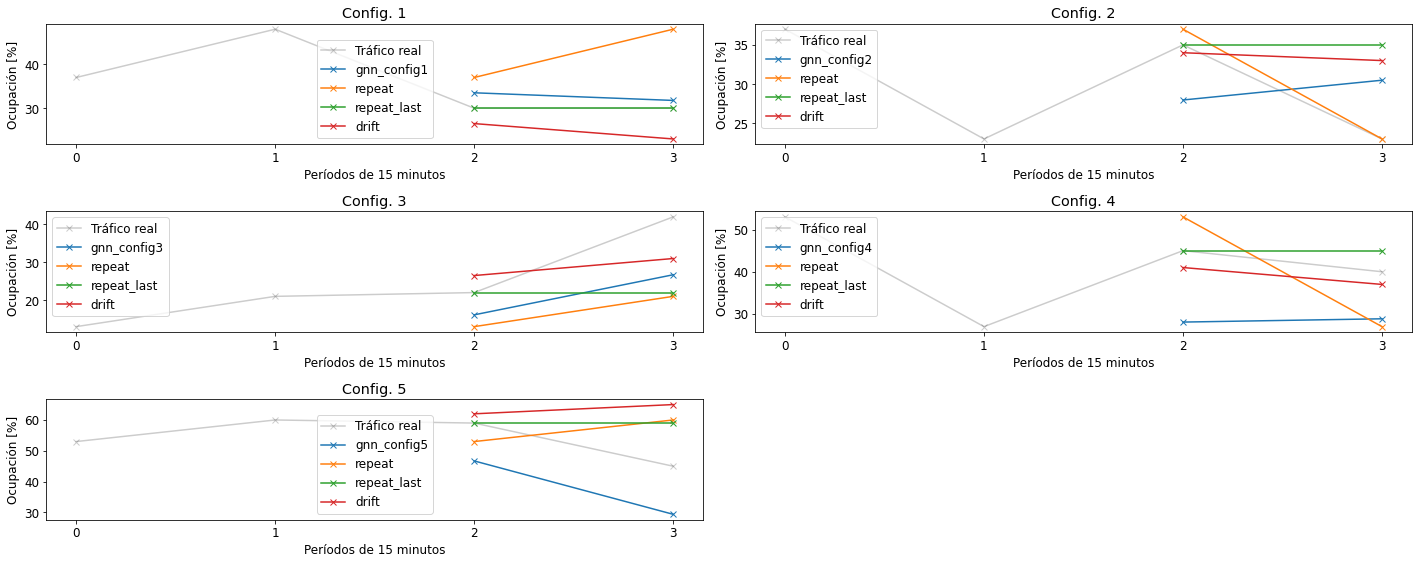

In [26]:
get_plot("Jul", 2, ids_list[0])

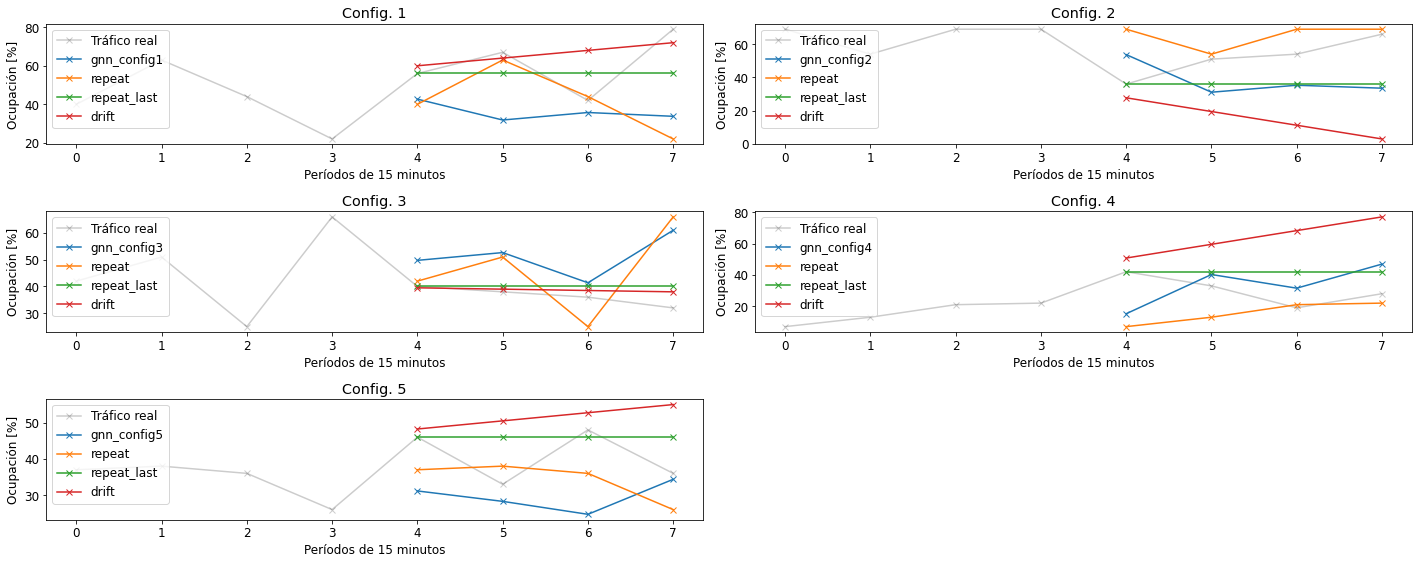

In [27]:
get_plot("Jul", 4, ids_list[0])

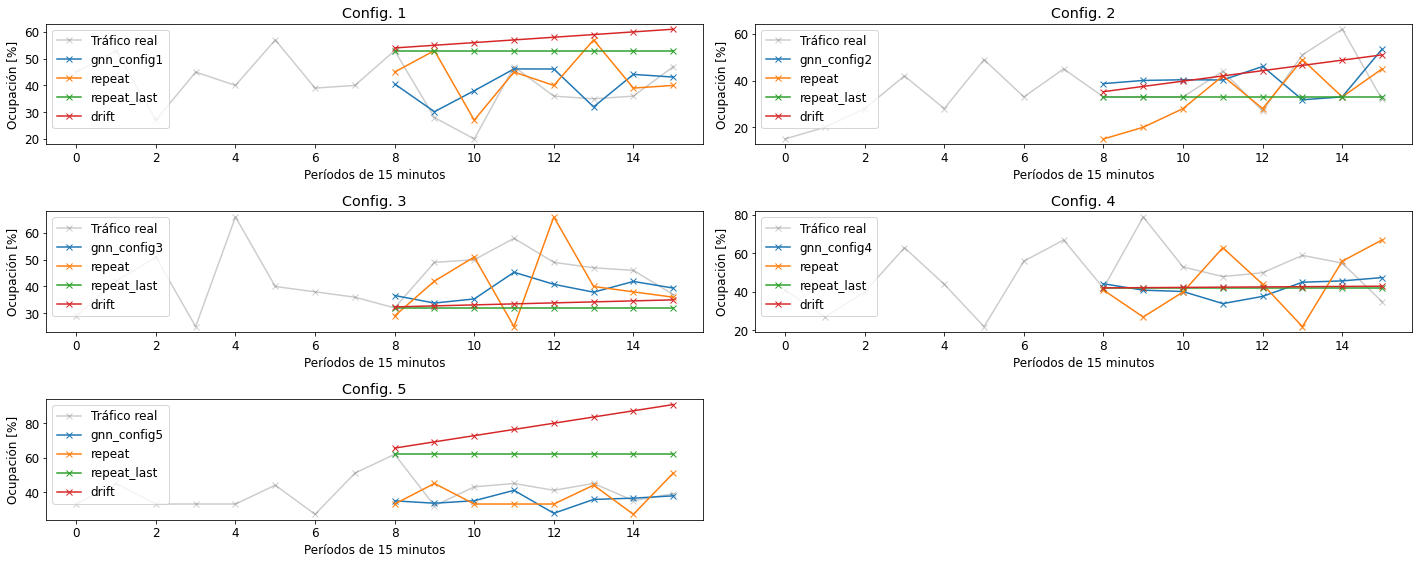

In [28]:
get_plot("Jul", 8, ids_list[0])

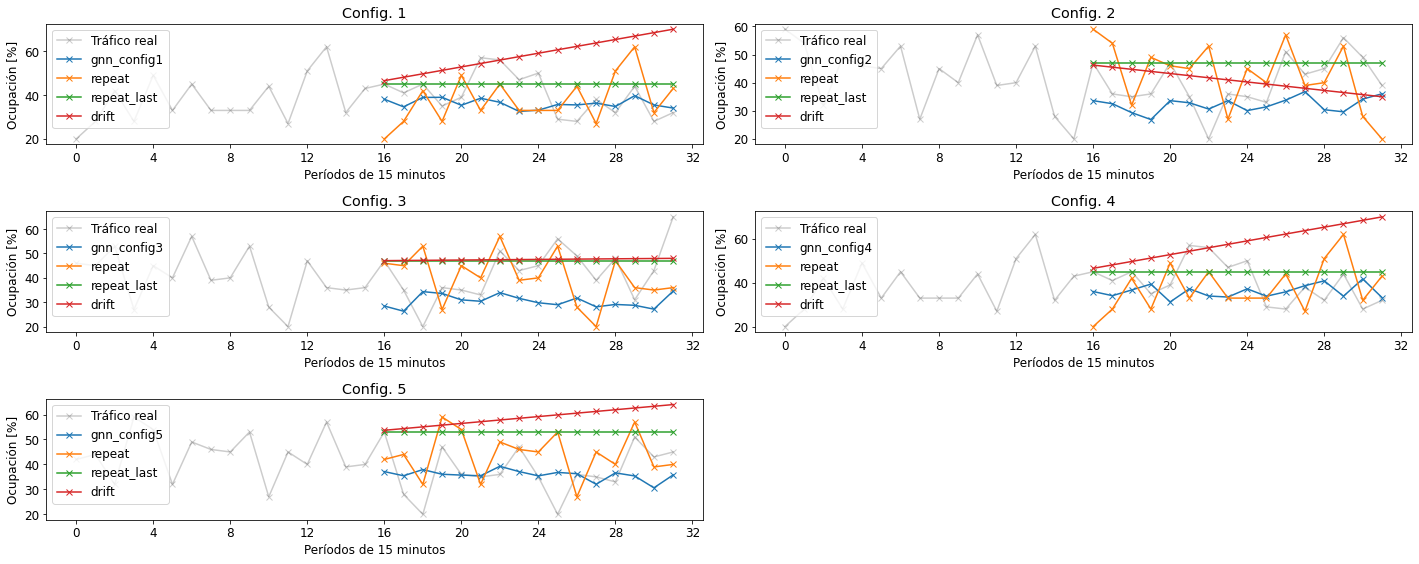

In [29]:
get_plot("Jul", 16, ids_list[0])